In [1]:
% matplotlib inline
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms 

In [3]:
transform = transforms.ToTensor()

batch_size = 64

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)

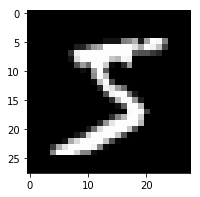

In [4]:
train_dataiterator = iter(train_loader)
images, labels = train_dataiterator.next()

images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = F.tanh(self.fc4(x))
        
        return x

In [7]:
input_size = 784
d_hidden_dim = 32
d_output_size = 1

z_size = 100
g_hidden_dim = 32
g_output_size = 784

In [8]:
D = Discriminator(input_size, d_hidden_dim, d_output_size)
G = Generator(z_size,g_hidden_dim, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [9]:
def d_real_loss(d_out, smooth=False):
    batch_size = d_out.size(0)
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    
    return loss

def d_fake_loss(d_out):
    batch_size = d_out.size(0)
    
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(d_out.squeeze(), labels)
    
    return loss

In [10]:
import torch.optim as optim 

lr = 0.002

d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

In [11]:
import pickle as pkl 

num_epochs = 100
print_every = 400
samples = []
losses = []

sample_size = 16 

fixed_z = np.random.uniform(-1,1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

In [12]:
print(fixed_z.shape)

torch.Size([16, 100])


In [13]:
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
        
        batch_size = real_images.size(0)
        
        real_images = real_images*2 - 1
        
        # train discriminator network
        D.zero_grad()
        real_output = D(real_images)
        
        # Compute real loss 
        real_loss = d_real_loss(real_output, True)
        
        # sample latent vector
        z = np.random.uniform(-1,1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        fake_output = D(G(z))
        
        # Compute fake loss
        fake_loss = d_fake_loss(fake_output)
        
        # total discriminator loss
        d_total_loss = real_loss + fake_loss 
        
        # sample latent vector
        z = np.random.uniform(-1,1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        #train generator network
        G.zero_grad()
        fake_images = G(z)
        
        g_out =  D(fake_images)
        
        #Compute generator loss (real loss on fake images)
        g_loss = d_real_loss(g_out, True)
        
        # backprop D and G networks with step
        d_total_loss.backward()
        d_optimizer.step()
        
        g_loss.backward()
        g_optimizer.step()
        
        # print epoch, d_loss, g_loss every 400 steps
        if batch_i % print_every == 0:
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_total_loss.item(), g_loss.item()))
    
    # append d_loss and g_loss every epoch
    losses.append((d_total_loss.item(), g_loss.item()))

    #generate sample after end of every epoch and append to list
    G.eval()
    sample_z = G(fixed_z)
    samples.append(sample_z)

# save generates samples to file    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)    
    
    

Epoch [    1/  100] | d_loss: 1.3904 | g_loss: 0.6392
Epoch [    1/  100] | d_loss: 1.0091 | g_loss: 2.7067
Epoch [    1/  100] | d_loss: 1.1809 | g_loss: 1.0560
Epoch [    2/  100] | d_loss: 0.6983 | g_loss: 2.8472
Epoch [    2/  100] | d_loss: 0.8645 | g_loss: 1.9079
Epoch [    2/  100] | d_loss: 0.6140 | g_loss: 3.7366
Epoch [    3/  100] | d_loss: 0.9163 | g_loss: 2.6114
Epoch [    3/  100] | d_loss: 0.7424 | g_loss: 2.2840
Epoch [    3/  100] | d_loss: 1.0684 | g_loss: 0.8753
Epoch [    4/  100] | d_loss: 0.9322 | g_loss: 1.8240
Epoch [    4/  100] | d_loss: 0.9040 | g_loss: 1.7213
Epoch [    4/  100] | d_loss: 0.9323 | g_loss: 1.9775
Epoch [    5/  100] | d_loss: 0.9082 | g_loss: 1.6517
Epoch [    5/  100] | d_loss: 1.0401 | g_loss: 1.5131
Epoch [    5/  100] | d_loss: 1.1046 | g_loss: 1.3798
Epoch [    6/  100] | d_loss: 1.3706 | g_loss: 1.3255
Epoch [    6/  100] | d_loss: 0.9410 | g_loss: 1.2099
Epoch [    6/  100] | d_loss: 1.0056 | g_loss: 1.1393
Epoch [    7/  100] | d_loss

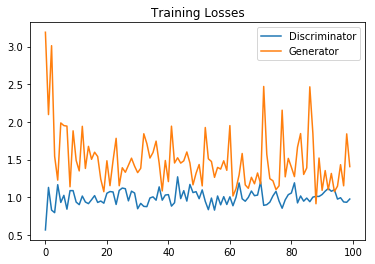

In [15]:
# plot Generator and Discriminator Loss with epoch
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title('Training Losses')
plt.legend()

In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [20]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    

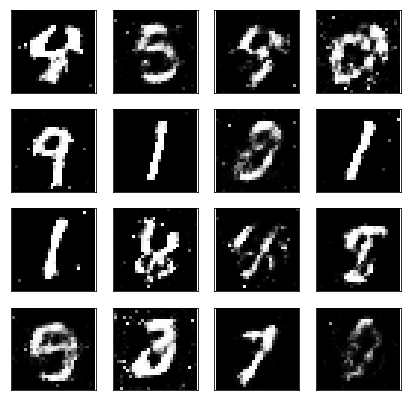

In [21]:
view_samples(-1, samples)

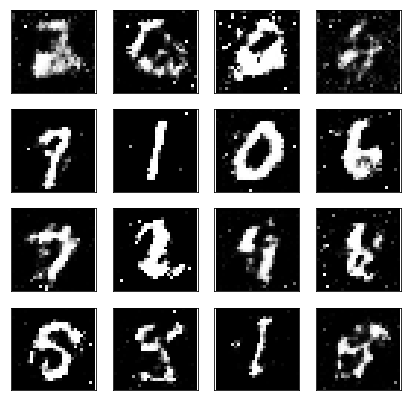

In [23]:
sample_size = 16 

z = np.random.uniform(-1,1, size=(sample_size, 100))
z = torch.from_numpy(z).float()

G.eval()
generated_samples = G(z)

view_samples(0, [generated_samples])